<a href="https://colab.research.google.com/github/shirleyzz/cap5610_machineleanrning/blob/master/HW3/Problem3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing heatmaps of class activation

In [54]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-17 03:02:27--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  54.8MB/s    in 1.2s    

2019-04-17 03:02:28 (54.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [0]:
# for file in os.listdir(validation_cats_dir):
#   img_path1 = file
#   print(file)

In [0]:
from keras.applications import VGG19
conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

In [0]:
from keras import layers
from keras import models
from keras import optimizers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [65]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 22s 219ms/step - loss: 0.5810 - acc: 0.7015 - val_loss: 0.4456 - val_acc: 0.7980
Epoch 2/100
100/100 [==============================] - 18s 183ms/step - loss: 0.4124 - acc: 0.8210 - val_loss: 0.3182 - val_acc: 0.8620
Epoch 3/100
100/100 [==============================] - 18s 184ms/step - loss: 0.3478 - acc: 0.8440 - val_loss: 0.2545 - val_acc: 0.8920
Epoch 4/100
100/100 [==============================] - 18s 185ms/step - loss: 0.3041 - acc: 0.8725 - val_loss: 0.2417 - val_acc: 0.9050
Epoch 5/100
100/100 [==============================] - 19s 195ms/step - loss: 0.2721 - acc: 0.8875 - val_loss: 0.2263 - val_acc: 0.9100
Epoch 6/100
100/100 [==============================] - 19s 188ms/step - loss: 0.2599 - acc: 0.8980 - val_loss: 0.3336 - val_acc: 0.8800
Epoch 7/100
100/100 [==============================] - 19s 187ms/step - loss: 0.2551 - acc: 0.8930 - val_loss: 0.1927 - val_acc: 0.9270
Epoch 8/100
100/100 [===========================

In [0]:
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K

In [0]:

def show_superimposed_image(img_path, heatmap):

  img = cv2.imread(img_path)
  # resize the heatmap to be the same size as the original image
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = heatmap * 0.4 + img

  cv2_imshow(superimposed_img)

In [0]:
def process_image(img_path, idx=0):
  img = image.load_img(img_path, target_size=(150, 150))
  #
  plt.imshow(img)
  plt.grid(None)
  plt.show()
  #
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  #
  preds = model.predict(x)
  print('Predicted:', decode_predictions(preds, top=3)[0])
  #
  #class_index = np.argmax(preds[0])
  class_index = np.argsort(preds[0])[-(1+idx)]
  class_output = model.output[:, class_index]
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  #
  show_superimposed_image(img_path, heatmap)

In [0]:
validation_cats_dir
img_path1 = os.path.join(validation_cats_dir,'cat1.jpg')

In [89]:
img_path1

'/tmp/cats_and_dogs_filtered/validation/cats/cat1.jpg'

In [0]:
pic = cv2.imread(img_path1)

In [0]:
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
img_path1 = os.path.join(validation_cats_dir,'cat.2200.jpg')
# img_path2 = 'tank2.jpg'
# img_path3 = 'tank3.jpg'
# img_path4 = 'tank4.jpg'
# img_path5 = 'tank5.png'
# img_path6 = 'elephant.jpg'

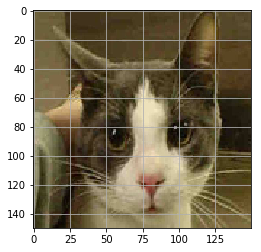

ValueError: ignored

In [92]:
process_image(img_path1)

In [0]:
process_image(img_path2)

In [0]:
process_image(img_path3, idx=1)

In [0]:
process_image(img_path4)

In [0]:
process_image(img_path5)

In [0]:
process_image(img_path6)